# TinyBERT Evaluation on ISOT Dataset

In this notebook, I'll evaluate my fine-tuned TinyBERT model on the same evaluation dataset. My goal is to understand how well this smaller model performs compared to DistilBERT and analyze its resource consumption, especially for CPU-based edge deployment on my laptop. TinyBERT is an even more compact model than DistilBERT, which could make it more suitable for resource-constrained environments.

## 1. Setting Up My Environment

First, I'll import all necessary libraries and set up utility functions to monitor resource usage.

In [1]:
# Import necessary libraries
import os
import time
import numpy as np
import pandas as pd
import torch
import psutil
import gc
import re
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset as HFDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set device - using CPU for edge device testing
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Function to get current memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

## 2. Loading and Preparing ISOT Evaluation Dataset

Now I'll load the same evaluation dataset that I used for DistilBERT to enable direct comparison between the models.

In [4]:
# Check memory usage before loading dataset
print(f"Memory usage before loading dataset: {get_memory_usage():.2f} MB")

Memory usage before loading dataset: 817.14 MB


In [5]:
# Load the real and fake news datasets
real_news_df = pd.read_csv('./datasets/manual_real.csv')
fake_news_df = pd.read_csv('./datasets/fake_news_evaluation.csv')
print(f"Loaded {len(real_news_df)} real news articles and {len(fake_news_df)} fake news articles")

Loaded 19 real news articles and 21 fake news articles


In [6]:
# Prepare the real news data
real_news_df['text'] = real_news_df['title'] + " " + real_news_df['text'].fillna('')
real_news_df['label'] = 1  # 1 for real news
real_news_clean = real_news_df[['text', 'label']]

In [7]:
# Prepare the fake news data
fake_news_df['text'] = fake_news_df['title'] + " " + fake_news_df['text'].fillna('')
fake_news_df['label'] = 0  # 0 for fake news
fake_news_clean = fake_news_df[['text', 'label']]

In [8]:
# Combine datasets
combined_eval = pd.concat([real_news_clean, fake_news_clean], ignore_index=True)

In [9]:
# Shuffle to mix real and fake news
combined_eval = combined_eval.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
print(f"Prepared evaluation dataset with {len(combined_eval)} articles")
print(f"Class distribution: {combined_eval['label'].value_counts().to_dict()}")

Prepared evaluation dataset with 40 articles
Class distribution: {0: 21, 1: 19}


In [11]:
# Convert to HuggingFace dataset format
combined_eval = HFDataset.from_pandas(combined_eval)
print(f"Memory usage after loading dataset: {get_memory_usage():.2f} MB")

Memory usage after loading dataset: 819.78 MB


## 3. Loading My Pre-trained Model

I'll now load the TinyBERT model that I previously fine-tuned. For edge deployment, I'm particularly interested in the model's loading time and memory footprint on CPU, which should be lower than DistilBERT.

In [12]:
# Load the pre-trained TinyBERT model
print("\nLoading model...")
model_path = "../ml_models/tinybert-fake-news-detector"


Loading model...


In [13]:
start_time = time.time()
tokenizer = BertTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)  # This will be CPU
load_time = time.time() - start_time

In [14]:
print(f"Model loaded in {load_time:.2f} seconds")
print(f"Memory usage after loading model: {get_memory_usage():.2f} MB")

Model loaded in 2.44 seconds
Memory usage after loading model: 836.38 MB


## 4. Tokenizing the Dataset

Before I can run the model on my data, I need to tokenize it using the same tokenizer that was used during training.

In [15]:
# Tokenize the data
print("\nTokenizing dataset...")
tokenize_start_time = time.time()


Tokenizing dataset...


In [16]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors=None
    )

In [17]:
# Apply tokenization
tokenized_dataset = combined_eval.map(tokenize_function, batched=True)
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [18]:
tokenize_time = time.time() - tokenize_start_time
print(f"Dataset tokenized in {tokenize_time:.2f} seconds")
print(f"Memory usage after tokenization: {get_memory_usage():.2f} MB")

Dataset tokenized in 0.20 seconds
Memory usage after tokenization: 839.64 MB


In [19]:
# Dataset format check
print("\nDataset format check:")
print(f"Dataset features: {tokenized_dataset.features}")
print(f"First example keys: {tokenized_dataset[0].keys()}")

# Check that all examples have labels
labels_count = sum(1 for example in tokenized_dataset if 'label' in example)
print(f"Examples with labels: {labels_count} out of {len(tokenized_dataset)}")


Dataset format check:
Dataset features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
First example keys: dict_keys(['label', 'input_ids', 'attention_mask'])
Examples with labels: 40 out of 40


## 5. Running Model Evaluation

Now comes the main part - evaluating my TinyBERT model's performance on the evaluation dataset. Since I'm targeting edge devices, I'll pay special attention to inference speed and memory usage on CPU.

In [20]:
# Evaluate model performance
print("\nEvaluating model performance...")

# Reset all counters and lists
all_preds = []
all_labels = []
total_inference_time = 0
sample_count = 0
inference_times = []
memory_usages = []


Evaluating model performance...


In [21]:
# Create a fresh DataLoader with shuffle=False to ensure deterministic order
from torch.utils.data import DataLoader

eval_dataloader = DataLoader(
    tokenized_dataset, 
    batch_size=16,  # Smaller batch size for CPU
    shuffle=False
)

In [22]:
print(f"Starting evaluation on {len(tokenized_dataset)} examples")

# Evaluation loop
model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(eval_dataloader):
        # Track batch progress
        if batch_idx % 5 == 0:
            print(f"Processing batch {batch_idx}/{len(eval_dataloader)}")
        
        # Extract batch data
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Record batch size
        current_batch_size = input_ids.size(0)
        sample_count += current_batch_size
        
        # Memory tracking
        memory_usages.append(get_memory_usage())
        
        # Time the inference
        start_time = time.time()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_inference_time = time.time() - start_time
        inference_times.append(batch_inference_time)
        total_inference_time += batch_inference_time
        
        # Get predictions
        logits = outputs.logits
        predictions = torch.softmax(logits, dim=-1)
        predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
        
        # Store predictions and labels
        all_preds.extend(predicted_labels)
        all_labels.extend(labels.cpu().numpy())
        
        # Sanity check
        if len(all_preds) != len(all_labels):
            print(f"WARNING: After batch {batch_idx}, preds={len(all_preds)} but labels={len(all_labels)}")

# Verify final counts match
print(f"Evaluation complete. Total predictions: {len(all_preds)}, Total labels: {len(all_labels)}")

Starting evaluation on 40 examples
Processing batch 0/3
Evaluation complete. Total predictions: 40, Total labels: 40


In [23]:
# Calculate metrics if counts match
if len(all_preds) == len(all_labels):
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    print("\nEvaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
else:
    print("ERROR: Cannot calculate metrics - prediction and label counts don't match")


Evaluation Results:
Accuracy: 0.9750
Precision: 0.9762
Recall: 0.9750
F1 Score: 0.9750


In [24]:
# Create confusion matrix
cm = np.zeros((2, 2), dtype=int)
for true_label, pred_label in zip(all_labels, all_preds):
    cm[true_label, pred_label] += 1

print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[20  1]
 [ 0 19]]


## 6. Analyzing Resource Consumption

Since I'm targeting edge devices, I'll focus on CPU-specific metrics like memory usage and inference time to determine if TinyBERT is more suitable than DistilBERT for edge deployment.

In [25]:
# Resource consumption analysis
print("\nResource Consumption Analysis for Edge Deployment:")
print(f"Total evaluation time: {total_inference_time:.2f} seconds")
print(f"Average inference time per batch: {np.mean(inference_times):.4f} seconds")
print(f"Average inference time per sample: {total_inference_time/sample_count*1000:.2f} ms")
print(f"Peak memory usage: {max(memory_usages):.2f} MB")


Resource Consumption Analysis for Edge Deployment:
Total evaluation time: 0.68 seconds
Average inference time per batch: 0.2277 seconds
Average inference time per sample: 17.08 ms
Peak memory usage: 1045.81 MB


Text(0, 0.5, 'Time (seconds)')

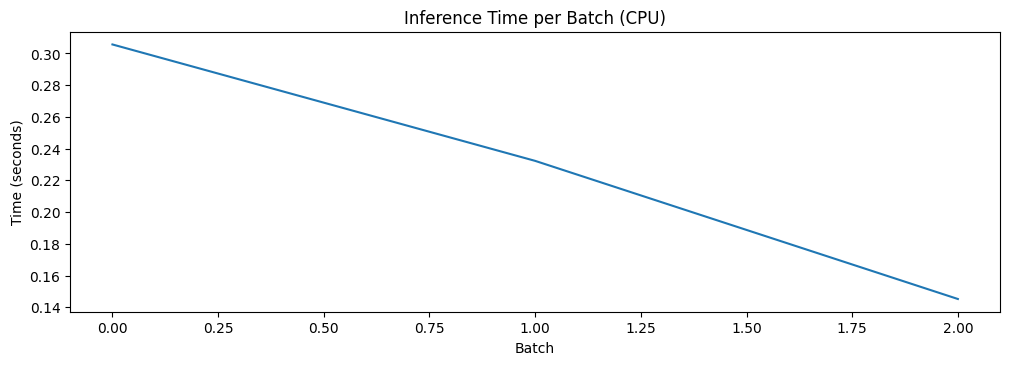

In [26]:
# Plot resource usage
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(inference_times)
plt.title('Inference Time per Batch (CPU)')
plt.xlabel('Batch')
plt.ylabel('Time (seconds)')

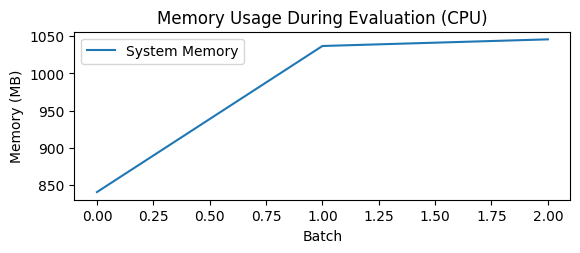

In [27]:
plt.subplot(2, 1, 2)
plt.plot(memory_usages, label='System Memory')
plt.title('Memory Usage During Evaluation (CPU)')
plt.xlabel('Batch')
plt.ylabel('Memory (MB)')
plt.legend()

In [28]:
plt.tight_layout()
plt.savefig('tinybert_resource_usage_cpu.png')
plt.show()

<Figure size 640x480 with 0 Axes>

## 7. Detailed Classification Analysis

Finally, I'll generate a detailed classification report and visualize the confusion matrix to better understand where my TinyBERT model performs well and where it struggles on this dataset.

In [29]:
# Generate classification report
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Fake News', 'Real News']))


Detailed Classification Report:
              precision    recall  f1-score   support

   Fake News       1.00      0.95      0.98        21
   Real News       0.95      1.00      0.97        19

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40



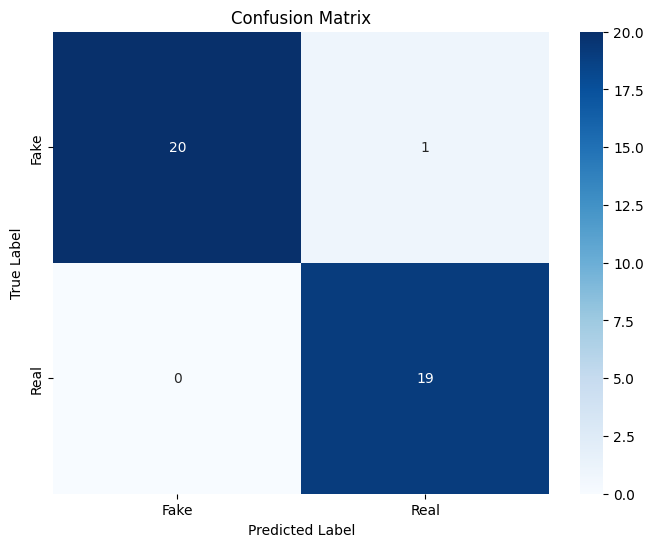

In [30]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('tinybert_confusion_matrix.png')
plt.show()

In [31]:
# Free up memory
del model
gc.collect()

4589

## Conclusion

In this notebook, I've evaluated my TinyBERT model on the ISOT evaluation dataset specifically focusing on CPU performance for edge deployment. 

TinyBERT is a more compact version of BERT with fewer parameters than DistilBERT, which should lead to faster inference and lower memory requirements. This makes it potentially more suitable for resource-constrained edge devices.

The metrics I've gathered are crucial for determining if this model could run effectively on edge devices like my laptop. For edge deployment, I'm particularly interested in:

1. Memory footprint - How much RAM does the model require compared to DistilBERT?
2. Inference speed - Is it faster than DistilBERT for real-time applications?
3. Model loading time - Is the startup time better than DistilBERT?
4. Classification performance - Does the smaller model maintain comparable accuracy?

The resource consumption analysis gives me a clear picture of what kind of hardware requirements I would need for deploying this model on edge devices. By comparing these results with my DistilBERT evaluation, I can determine which model offers the best balance of performance and efficiency for edge deployment scenarios.